In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [15]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [8]:
niter = 3
ibatch = 0

# load model
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

# load SpenderQ recon 
w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)
recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.recons.npy' % (niter, ibatch))

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [9]:
# load picca
picca = U.london_picca()

In [20]:
# select high-z and bright (high normalization) quasars
highzs = np.arange(len(z))[(z > 3.) & (norm > 2.)][:4]

/tmp/ipykernel_582339/1059914188.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


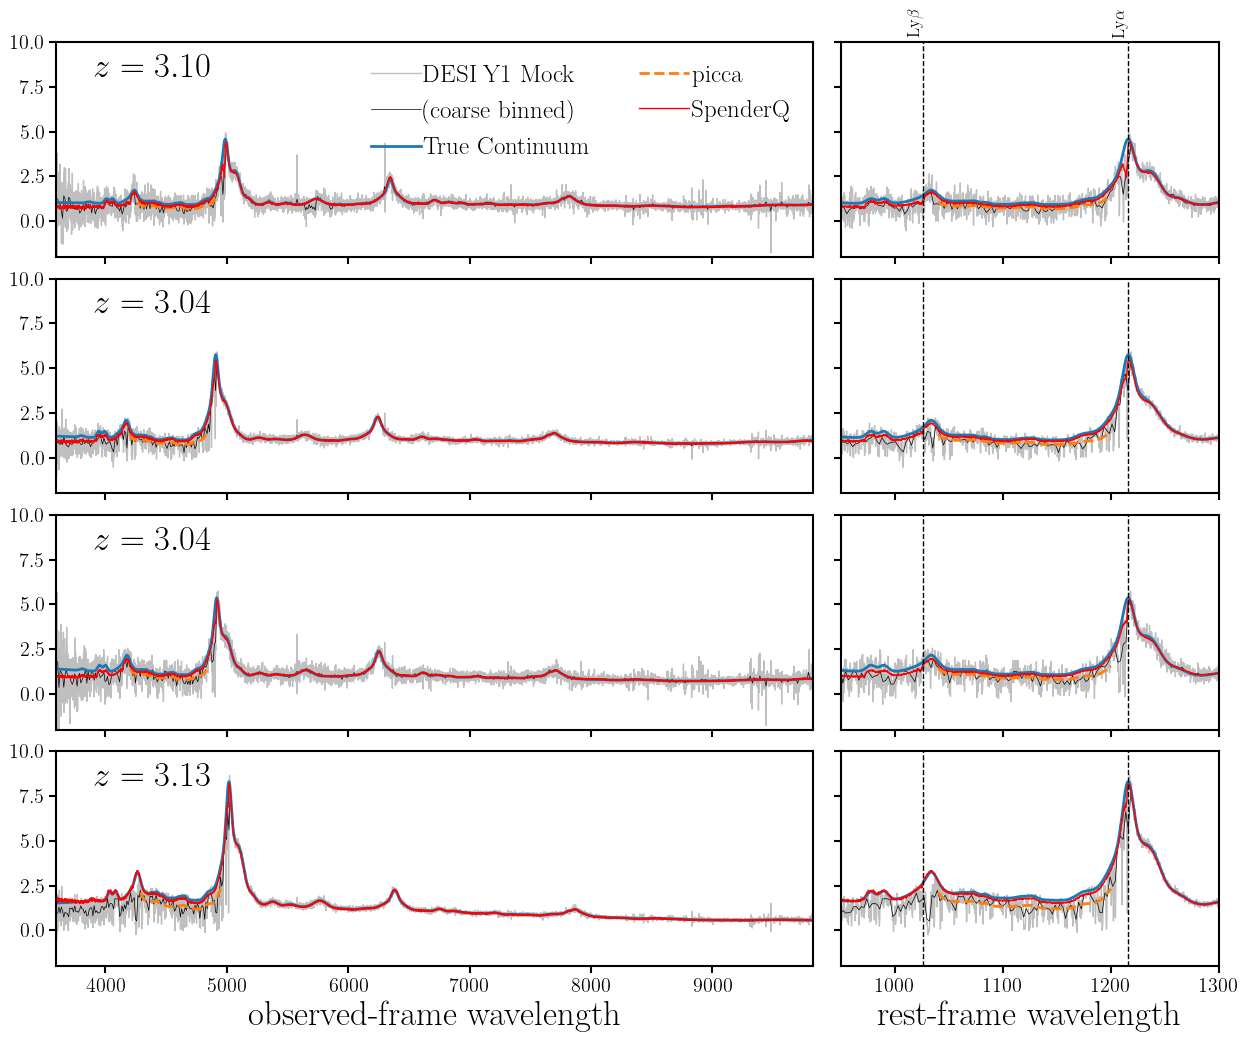

In [42]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(len(highzs), 2, width_ratios=[2, 1]) 

# observed-frame full spectra
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii])
    
    # full spectra
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.5, lw=1, label='DESI Y1 Mock')
    
    # coarse spectra
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=0.5, label='(coarse binned)')
    
    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
    # picca 
    spec_picca = picca.get_continuum(int(target_id[igal]))
    sub.plot(picca.wave_picca * np.array(1+z[igal]), spec_picca/norm[igal], color='C1', lw=2, ls='--', label='picca')
    
    # spenderq recon
    sub.plot(models[0].wave_rest * (1+z[igal]), recon[igal], color='r', lw=1, label=r'SpenderQ')
    sub.text(0.05, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', ncol=2, fontsize=18, handletextpad=0.1)
    sub.set_ylim(-2, 10.)
sub.set_xlabel("observed-frame wavelength", fontsize=25)

# zoom in rest-frame LyA region 
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii+1])    
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='DESI')
    #sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=0.5)

    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1+z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
    # picca 
    spec_picca = picca.get_continuum(int(target_id[igal]))
    sub.plot(picca.wave_picca, spec_picca/norm[igal], color='C1', lw=2, ls='--', label='picca')
    
    
    sub.plot(models[0].wave_rest, recon[igal], color='r', lw=1, label=r'SpenderQ')
    

    sub.axvline(1026, color='k', linewidth=1, linestyle='--')
    sub.axvline(1216, color='k', linewidth=1, linestyle='--')
    if ii == 0:     
        sub.text(1026, 11.8, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
        sub.text(1216, 11.8, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

    sub.set_xlim(950., 1300.)
    if ii < len(highzs)-1: sub.set_xticklabels([])
    sub.set_ylim(-2, 10.)
    sub.set_yticklabels([])
    
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.savefig('spenderq_mock_recon.pdf', bbox_inches='tight')